In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grb-nasa-datasett1/browse_results.xls


# Self-Organising Map

Self-Organizing Maps (SOM) are a type of artificial neural network that is trained using unsupervised learning to produce a low-dimensional, discretized representation of the input space of the training samples, called a map. They are useful for visualizing high-dimensional data.

It is basically used for dimensional reduction. The SOM is not merely a clustering technique:it can also be used to visualize the input data set,since it attempts to represent the topological ordering of the input data in the ordering of the map unit reference vectors.

In this project, I have classified the Gamma - Ray Bursts(GRBs) using Self-organising Map. As we know GRBs can be classified into Long-soft and short-hard classes which has been identified by the help of BATSE-NASA catalog using the burst duration parameter T90 (the time it takes for 90% of the total burst flux to arrive).

It has been noted that there is a dividing line around T90 ~ 2s.
* T90 > 2s --> Long GRBs
* T90 < 2s --> ShortGRBs

However, this cannot be the one- and only way to classify, hence we'll be applying SOM on the dataset and know about the relevamt features from the manuscript attached.

In [2]:
# Importing SOM and required libraries

!pip install minisom
from minisom import MiniSom
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

  Preparing metadata (setup.py) ... - \ done
  Created wheel for minisom: filename=MiniSom-2.3.2-py3-none-any.whl size=10650 sha256=78f9c7354726ed17f57aefec0534aae5d7d9a952284c9d8aedb78b1ba1fecb5d
  Stored in directory: /root/.cache/pip/wheels/b4/f6/8a/9daf8831901c3e3805775633404248f10663d1c80b7e5a1314
Successfully built minisom


In [3]:
!pip install xlrd

# Conversion to excel path to CSV file
excel_path = '/kaggle/input/grb-nasa-datasett1/browse_results.xls'

csv_path = '/kaggle/working/browse_results.csv'
df = pd.read_excel(excel_path, sheet_name='batsegrb')

df.to_csv(csv_path, index=False)
print(f'Converted {excel_path} to {csv_path}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 2.9 MB/s eta 0:00:00
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
Converted /kaggle/input/grb-nasa-datasett1/browse_results.xls to /kaggle/working/browse_results.csv


## Exploratory Data Analysis

In [4]:
# Missing vlaues in columns
sns.heatmap(df.isnull(),yticklabels = False,cbar = False, cmap ='viridis')

<Axes: >

In [5]:
print(df)
print(df.shape)

      flux_256     t50      t90     fluence_1     fluence_2     fluence_3
0          NaN     NaN      NaN           NaN           NaN           NaN
1       1.8037   0.104    0.240  7.801300e-09  2.304100e-08  1.007700e-07
2       0.6315   9.536   30.144  3.213700e-07  3.993300e-07  9.028400e-07
3       2.8020   1.728    8.384  3.528600e-07  2.814800e-07  3.213000e-07
4       0.3749   1.728    3.328  1.462900e-08  2.592300e-08  1.664800e-07
...        ...     ...      ...           ...           ...           ...
2697    0.9680   0.034    0.078  3.441500e-09  9.727600e-09  4.809400e-08
2698    0.6430   0.168    0.344  1.415100e-09  1.088800e-09  4.833400e-08
2699    1.6840  25.472  109.824  6.943100e-07  1.848600e-06  7.657900e-06
2700       NaN     NaN      NaN           NaN           NaN           NaN
2701    1.3340   4.160   11.264  2.175500e-07  2.071300e-07  4.321300e-07

[2702 rows x 6 columns]
(2702, 6)


### Data Cleaning

In [6]:
# Replacing NaN values with the median and creating required parameters
df_new = df.copy()
df_new = df_new.fillna(df_new.median())

# Identifying and removing outliers using IQR method
Q1 = df_new.quantile(0.25)
Q3 = df_new.quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those points that lie beyond 1.5 * IQR
df_new = df_new[~((df_new < (Q1 - 1.5 * IQR)) | (df_new > (Q3 + 1.5 * IQR))).any(axis=1)]

In [7]:
print(df_new.shape)
print(df_new.head(5))

(1926, 6)
   flux_256    t50     t90     fluence_1     fluence_2     fluence_3
0    1.2510  6.080  18.432  2.548400e-07  3.078400e-07  7.492100e-07
1    1.8037  0.104   0.240  7.801300e-09  2.304100e-08  1.007700e-07
2    0.6315  9.536  30.144  3.213700e-07  3.993300e-07  9.028400e-07
3    2.8020  1.728   8.384  3.528600e-07  2.814800e-07  3.213000e-07
4    0.3749  1.728   3.328  1.462900e-08  2.592300e-08  1.664800e-07


In [8]:
df_new.isnull().sum()

flux_256     0
t50          0
t90          0
fluence_1    0
fluence_2    0
fluence_3    0
dtype: int64

Hardness ratios HR32 (channel 3 fluence/channel 2 fluence)

HR 321 (channel 3 fluence divided by the sum of channel 2 fluence and channel 1 fluence)

$ HR321 = Fluence3/(Fluence 2 + Fluence 1) $

$ HR32 = Fluence3/(Fluence 2) $

In [9]:
df_new.loc[:,'log S (S = fluence2+fluence3)'] = np.log(df_new.loc[:,'fluence_2'] + df_new.loc[:,'fluence_3'])

df_new.loc[:,'log t90'] = np.log(df_new.loc[:,'t90'])

df_new.loc[:,'log HR32'] = np.log(df_new.loc[:,'fluence_3']/(df_new.loc[:,'fluence_2'].replace(0,np.nan)))
df_new.loc[:,'log HR321'] = np.log(df_new.loc[:,'fluence_3']/(df_new.loc[:,'fluence_2'] + df_new.loc[:,'fluence_1']).replace(0,np.nan))

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
# X1 = df_new.to_numpy()

# if np.isnan(X1).any():
#     raise ValueError("Data contains NaN values")

In [11]:
df_new.isnull().sum()

flux_256                          0
t50                               0
t90                               0
fluence_1                         0
fluence_2                         0
fluence_3                         0
log S (S = fluence2+fluence3)     0
log t90                           0
log HR32                         15
log HR321                         2
dtype: int64

In [12]:
df_new = df_new.fillna(df_new.median())

In [13]:
df_new.isnull().sum()

flux_256                         0
t50                              0
t90                              0
fluence_1                        0
fluence_2                        0
fluence_3                        0
log S (S = fluence2+fluence3)    0
log t90                          0
log HR32                         0
log HR321                        0
dtype: int64

In [14]:
df_new

flux_256     t50     t90     fluence_1     fluence_2     fluence_3  \
0       1.2510   6.080  18.432  2.548400e-07  3.078400e-07  7.492100e-07   
1       1.8037   0.104   0.240  7.801300e-09  2.304100e-08  1.007700e-07   
2       0.6315   9.536  30.144  3.213700e-07  3.993300e-07  9.028400e-07   
3       2.8020   1.728   8.384  3.528600e-07  2.814800e-07  3.213000e-07   
4       0.3749   1.728   3.328  1.462900e-08  2.592300e-08  1.664800e-07   
...        ...     ...     ...           ...           ...           ...   
2696    0.5980  20.800  42.208  4.235700e-07  4.745000e-07  1.027800e-06   
2697    0.9680   0.034   0.078  3.441500e-09  9.727600e-09  4.809400e-08   
2698    0.6430   0.168   0.344  1.415100e-09  1.088800e-09  4.833400e-08   
2700    1.2510   6.080  18.432  2.548400e-07  3.078400e-07  7.492100e-07   
2701    1.3340   4.160  11.264  2.175500e-07  2.071300e-07  4.321300e-07   

      log S (S = fluence2+fluence3)   log t90  log HR32  log HR321  
0                        -13.760029  2.914088  0.889439   0.286308  
1                        -15.904510 -1.427116  1.475565   1.183954  
2                        -13.551478  3.405986  0.815757   0.225322  
3                        -14.321714  2.126325  0.132314  -0.680210  
4                        -15.463674  1.202372  1.859745   1.412290  
...                             ...       ...       ...        ...  
2696                     -13.408513  3.742610  0.772914   0.134928  
2697                     -16.665903 -2.551046  1.598190   1.295284  
2698                     -16.822854 -1.067114  3.793059   2.960286  
2700                     -13.760029  2.914088  0.889439   0.286308  
2701                     -14.262955  2.421612  0.735380   0.017391  

[1926 rows x 10 columns]

In [15]:
# Descriptive statistics
df_new.describe()

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


flux_256          t50          t90     fluence_1     fluence_2  \
count  1926.000000  1926.000000  1926.000000  1.926000e+03  1.926000e+03   
mean      1.228369     5.890600    16.759901  2.278093e-07  2.649492e-07   
std       0.667205     5.631917    14.947897  2.266041e-07  2.480969e-07   
min       0.000000     0.006000     0.015000  0.000000e+00  0.000000e+00   
25%       0.754250     1.062000     2.938000  3.168400e-08  4.380950e-08   
50%       1.251000     6.080000    18.432000  2.548400e-07  3.078400e-07   
75%       1.260500     6.080000    18.432000  2.548400e-07  3.078400e-07   
max       3.893000    27.392000    79.296000  1.327800e-06  1.595400e-06   

          fluence_3  log S (S = fluence2+fluence3)      log t90     log HR32  \
count  1.926000e+03                    1926.000000  1926.000000  1926.000000   
mean   6.634988e-07                           -inf     2.007201         -inf   
std    6.200339e-07                            NaN     1.753733          NaN   
min    0.000000e+00                           -inf    -4.199705         -inf   
25%    1.649075e-07                     -15.328953     1.077728     0.851374   
50%    7.492100e-07                     -13.760029     2.914088     0.889439   
75%    7.492100e-07                     -13.760029     2.914088     1.346185   
max    3.828800e-06                     -12.222873     4.373188     3.923899   

         log HR321  
count  1926.000000  
mean          -inf  
std            NaN  
min           -inf  
25%       0.255232  
50%       0.286308  
75%       0.874050  
max       6.443911

In [16]:
# list1 will consist of row number containing -inf values, so drop these rows

list1 = []
for index, row in df_new.iterrows():
    if (row['log HR321'] < -1e9 or row['log HR321'] > 1e9 or row['log S (S = fluence2+fluence3)'] < -1e9 or row['log S (S = fluence2+fluence3)'] > 1e9 or  row['log HR32'] < -1e9 or row['log HR32'] > 1e9):
        list1.append(index)
        
list1

[1737, 2160, 2265, 2315, 2381]

In [17]:
df_final = df_new.copy()
df_final.drop(index = list1, inplace = True)
df_final.shape

(1921, 10)

In [18]:
df_final.drop(columns = ['fluence_1','fluence_2','fluence_3'],inplace = True)
df_final.describe()

flux_256          t50          t90  log S (S = fluence2+fluence3)  \
count  1921.000000  1921.000000  1921.000000                    1921.000000   
mean      1.230197     5.902802    16.794740                     -14.421346   
std       0.666893     5.633764    14.950632                       1.217840   
min       0.271000     0.006000     0.015000                     -18.147864   
25%       0.756700     1.088000     2.964000                     -15.316108   
50%       1.251000     6.080000    18.432000                     -13.760029   
75%       1.267000     6.080000    18.432000                     -13.760029   
max       3.893000    27.392000    79.296000                     -12.222873   

           log t90     log HR32    log HR321  
count  1921.000000  1921.000000  1921.000000  
mean      2.010352     1.062700     0.488174  
std       1.754384     0.619551     0.725912  
min      -4.199705    -2.814026    -3.775679  
25%       1.086540     0.853176     0.258224  
50%       2.914088     0.889439     0.286308  
75%       2.914088     1.347734     0.875205  
max       4.373188     3.923899     6.443911

In [19]:
df_final.isnull().sum()

flux_256                         0
t50                              0
t90                              0
log S (S = fluence2+fluence3)    0
log t90                          0
log HR32                         0
log HR321                        0
dtype: int64

In [20]:
df_final.loc[df_final['t90'] > 2]

df_final.loc[df_final['t90'] <= 2]

flux_256    t50    t90  log S (S = fluence2+fluence3)   log t90  \
1       1.8037  0.104  0.240                     -15.904510 -1.427116   
17      0.9301  0.048  0.675                     -16.844179 -0.393043   
19      0.6760  0.064  0.128                     -17.026428 -2.055725   
25      0.6920  0.192  0.768                     -16.699254 -0.263966   
29      1.6800  0.512  0.896                     -15.011168 -0.109815   
...        ...    ...    ...                            ...       ...   
2686    3.8300  0.088  0.360                     -15.189276 -1.021651   
2691    0.8720  0.026  0.090                     -16.781781 -2.407946   
2692    1.3590  0.418  0.708                     -15.492398 -0.345311   
2697    0.9680  0.034  0.078                     -16.665903 -2.551046   
2698    0.6430  0.168  0.344                     -16.822854 -1.067114   

      log HR32  log HR321  
1     1.475565   1.183954  
17    1.179290   0.774904  
19    1.244504   1.199160  
25    1.541444   1.246034  
29    2.739020   1.769410  
...        ...        ...  
2686  1.381325   0.914735  
2691  1.292565   0.997813  
2692  2.203212   1.620487  
2697  1.598190   1.295284  
2698  3.793059   2.960286  

[432 rows x 7 columns]

In [21]:
# Normalizing the features(Using different Models)

# from sklearn.preprocessing import StandardScaler
# thisInstance = StandardScaler()
# df_final_normalized = pd.DataFrame(thisInstance.fit_transform(df_final), columns=df_final.columns)

# quantization error: 0.21673654737597492

# from sklearn.preprocessing import RobustScaler
# thisInstance = RobustScaler()
# df_final_normalized = pd.DataFrame(thisInstance.fit_transform(df_final), columns=df_final.columns)

# quantization error: 0.2144392907176334

# from sklearn.preprocessing import PowerTransformer
# thisInstance = PowerTransformer()
# df_final_normalized = pd.DataFrame(thisInstance.fit_transform(df_final))

# quantization error: 0.21152001586113267


# Using MinMaxScaler normalisation technique as it has less quantisation error

from sklearn.preprocessing import MinMaxScaler
thisInstance = MinMaxScaler()
df_final_normalized =  pd.DataFrame(thisInstance.fit_transform(df_final))

# quantization error: 0.034180269616822724(written after the model error is calculated)

In [22]:
df_final_normalized.describe()

0            1            2            3            4  \
count  1921.000000  1921.000000  1921.000000  1921.000000  1921.000000   
mean      0.264825     0.215322     0.211649     0.628949     0.724383   
std       0.184123     0.205717     0.188578     0.205543     0.204643   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.134097     0.039509     0.037197     0.477934     0.616623   
50%       0.270569     0.221792     0.232300     0.740564     0.829801   
75%       0.274986     0.221792     0.232300     0.740564     0.829801   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                 5            6  
count  1921.000000  1921.000000  
mean      0.575359     0.417223  
std       0.091950     0.071031  
min       0.000000     0.000000  
25%       0.544263     0.394723  
50%       0.549645     0.397471  
75%       0.617662     0.455095  
max       1.000000     1.000000

In [23]:
df_final_normalized.columns = ['flux_256', 't50', 't90', 'log S (S = fluence2+fluence3)', 'log t90',
                               'log HR32', 'log HR321']

In [24]:
df_final_normalized

flux_256       t50       t90  log S (S = fluence2+fluence3)   log t90  \
0     0.270569  0.221792  0.232300                       0.740564  0.829801   
1     0.423164  0.003578  0.002838                       0.378626  0.323413   
2     0.099531  0.347988  0.380028                       0.775762  0.887179   
3     0.698785  0.062879  0.105561                       0.645765  0.737911   
4     0.028686  0.062879  0.041788                       0.453029  0.630135   
...        ...       ...       ...                            ...       ...   
1916  0.090282  0.759293  0.532196                       0.799892  0.926445   
1917  0.192435  0.001022  0.000795                       0.250120  0.192311   
1918  0.102706  0.005915  0.004150                       0.223631  0.365407   
1919  0.270569  0.221792  0.232300                       0.740564  0.829801   
1920  0.293484  0.151683  0.141888                       0.655682  0.772355   

      log HR32  log HR321  
0     0.549645   0.397471  
1     0.636634   0.485306  
2     0.538709   0.391503  
3     0.437277   0.302896  
4     0.693651   0.507649  
...        ...        ...  
1916  0.532351   0.382658  
1917  0.654833   0.496200  
1918  0.980582   0.659123  
1919  0.549645   0.397471  
1920  0.526780   0.371157  

[1921 rows x 7 columns]

In [25]:
df_final_normalized.isnull().sum()

flux_256                         0
t50                              0
t90                              0
log S (S = fluence2+fluence3)    0
log t90                          0
log HR32                         0
log HR321                        0
dtype: int64

In [26]:
df_final_normalized.describe()

flux_256          t50          t90  log S (S = fluence2+fluence3)  \
count  1921.000000  1921.000000  1921.000000                    1921.000000   
mean      0.264825     0.215322     0.211649                       0.628949   
std       0.184123     0.205717     0.188578                       0.205543   
min       0.000000     0.000000     0.000000                       0.000000   
25%       0.134097     0.039509     0.037197                       0.477934   
50%       0.270569     0.221792     0.232300                       0.740564   
75%       0.274986     0.221792     0.232300                       0.740564   
max       1.000000     1.000000     1.000000                       1.000000   

           log t90     log HR32    log HR321  
count  1921.000000  1921.000000  1921.000000  
mean      0.724383     0.575359     0.417223  
std       0.204643     0.091950     0.071031  
min       0.000000     0.000000     0.000000  
25%       0.616623     0.544263     0.394723  
50%       0.829801     0.549645     0.397471  
75%       0.829801     0.617662     0.455095  
max       1.000000     1.000000     1.000000

In [27]:
# Dropping Unrelevant features

features = ['log t90', 'log S (S = fluence2+fluence3)','log HR321']
labels = ['flux_256','t50','t90','log HR32']

df_final_normalized.drop(axis = 0, columns = labels, inplace = True)

In [28]:
df_final_normalized

log S (S = fluence2+fluence3)   log t90  log HR321
0                          0.740564  0.829801   0.397471
1                          0.378626  0.323413   0.485306
2                          0.775762  0.887179   0.391503
3                          0.645765  0.737911   0.302896
4                          0.453029  0.630135   0.507649
...                             ...       ...        ...
1916                       0.799892  0.926445   0.382658
1917                       0.250120  0.192311   0.496200
1918                       0.223631  0.365407   0.659123
1919                       0.740564  0.829801   0.397471
1920                       0.655682  0.772355   0.371157

[1921 rows x 3 columns]

In [29]:
# Checking for NaN values
print("Checking for NaN values:")
# if any NaN values are present
print(df_final_normalized.isna().any())  
# Count of NaN values
print(df_final_normalized.isna().sum())

# Checking for infinite values
print("\nChecking for infinite values:")
# if any infinite values are present
print(df_final_normalized.isin([np.inf, -np.inf]).any())  
# Count of NaN values
print(df_final_normalized.isin([np.inf, -np.inf]).sum())  

Checking for NaN values:
log S (S = fluence2+fluence3)    False
log t90                          False
log HR321                        False
dtype: bool
log S (S = fluence2+fluence3)    0
log t90                          0
log HR321                        0
dtype: int64

Checking for infinite values:
log S (S = fluence2+fluence3)    False
log t90                          False
log HR321                        False
dtype: bool
log S (S = fluence2+fluence3)    0
log t90                          0
log HR321                        0
dtype: int64


In [30]:
df_final_normalized.replace([np.inf, -np.inf], np.nan, inplace=True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


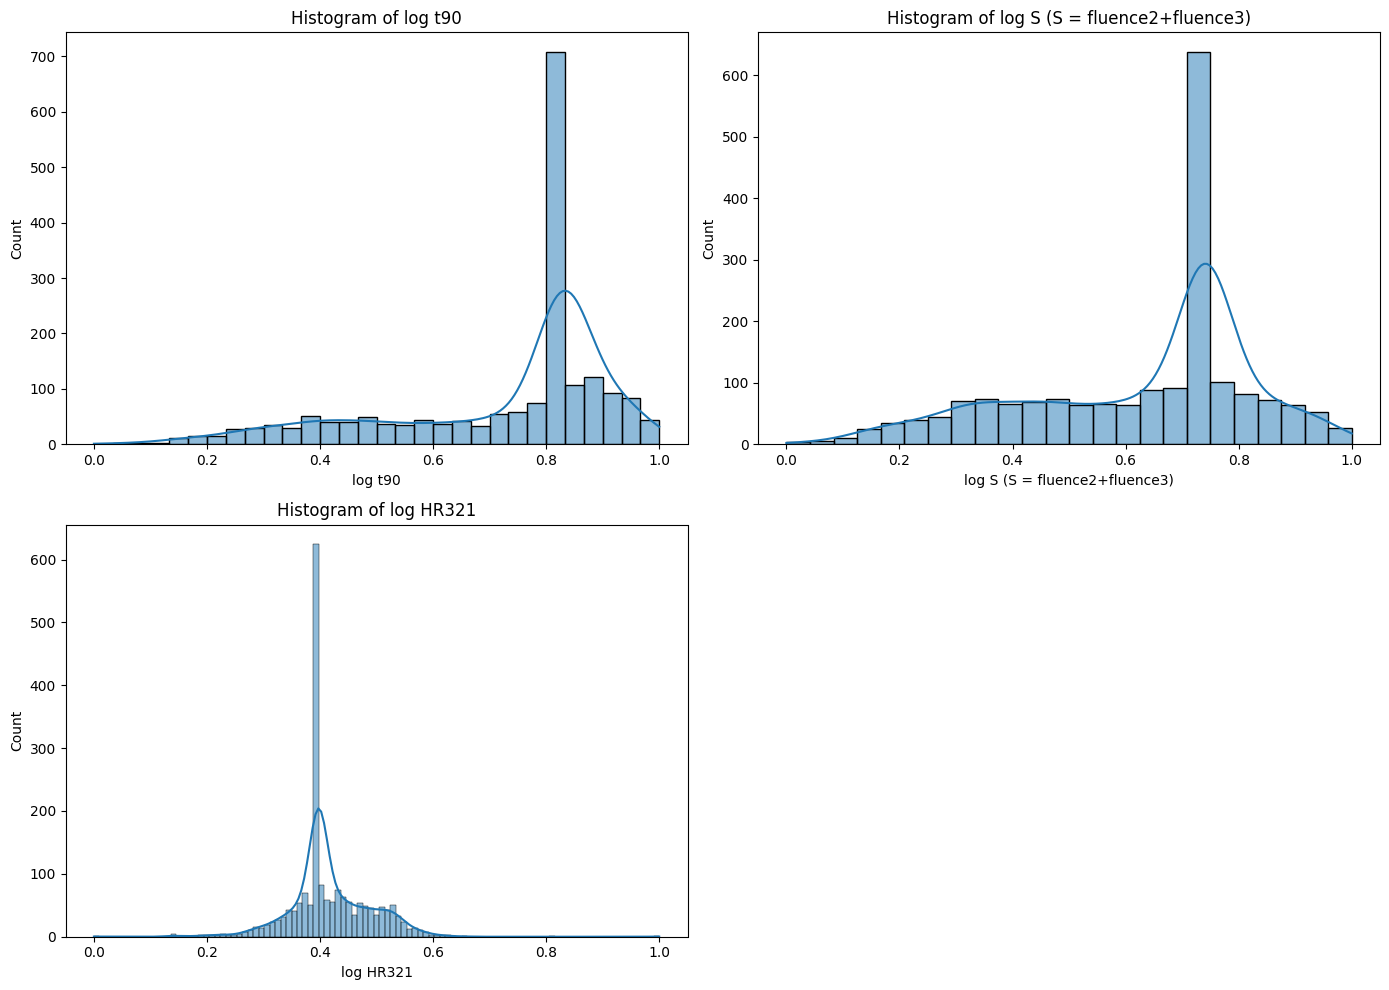

In [31]:
# Features to plot
features = ['log t90', 'log S (S = fluence2+fluence3)','log HR321']

# Histogram
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_final_normalized[feature], kde=True)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()


import warnings
# As there is no any inf or NaN values ,so I'll be supressing the warnings

# Suppress the specific FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

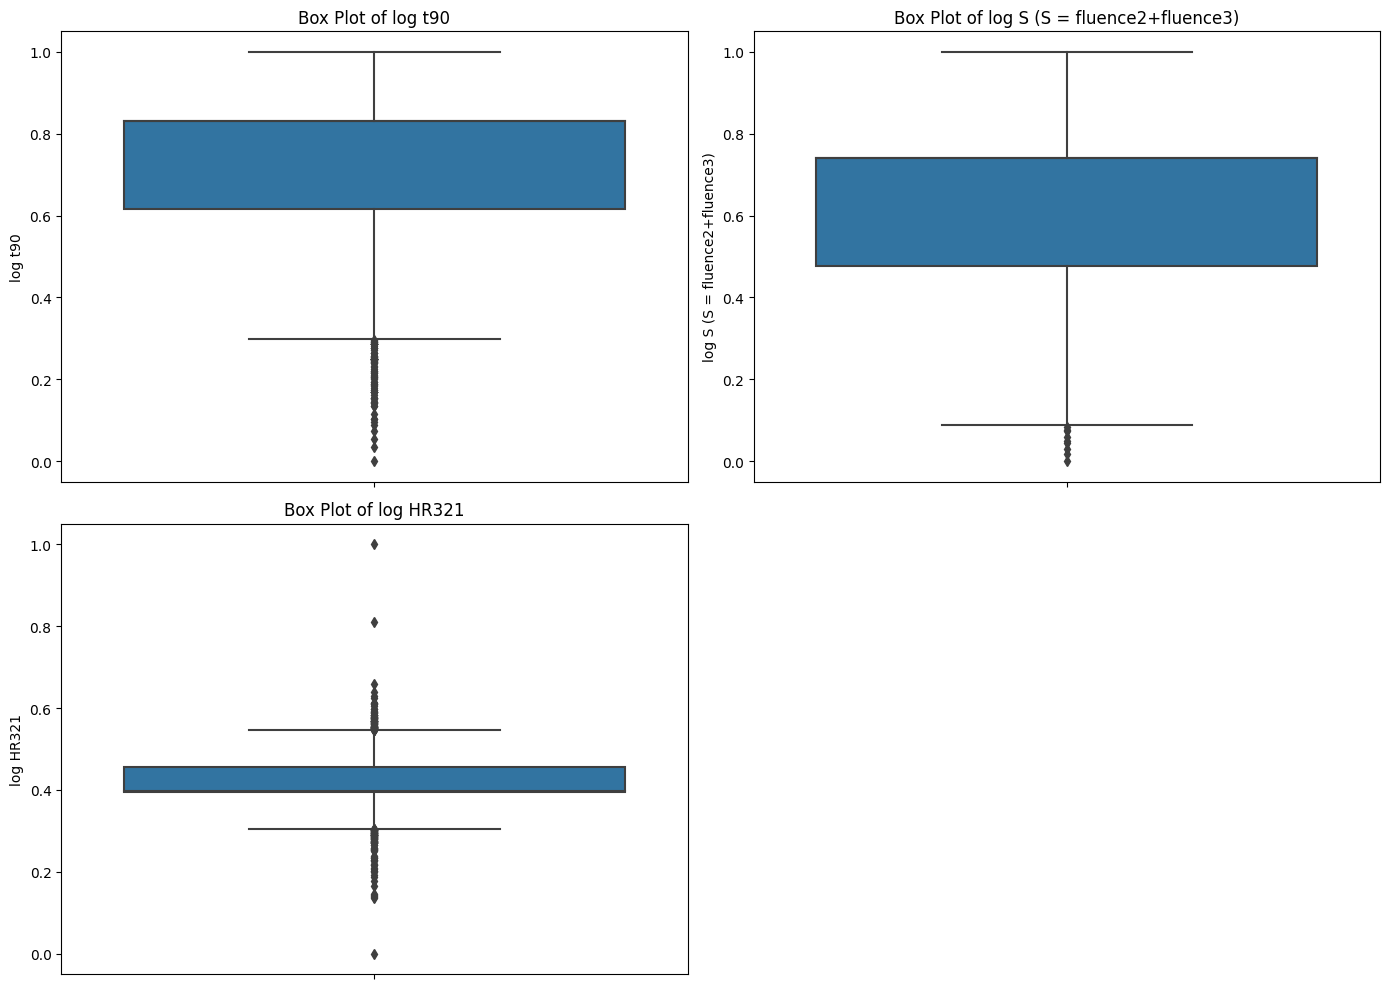

In [32]:
# Box Plot
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df_final_normalized[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

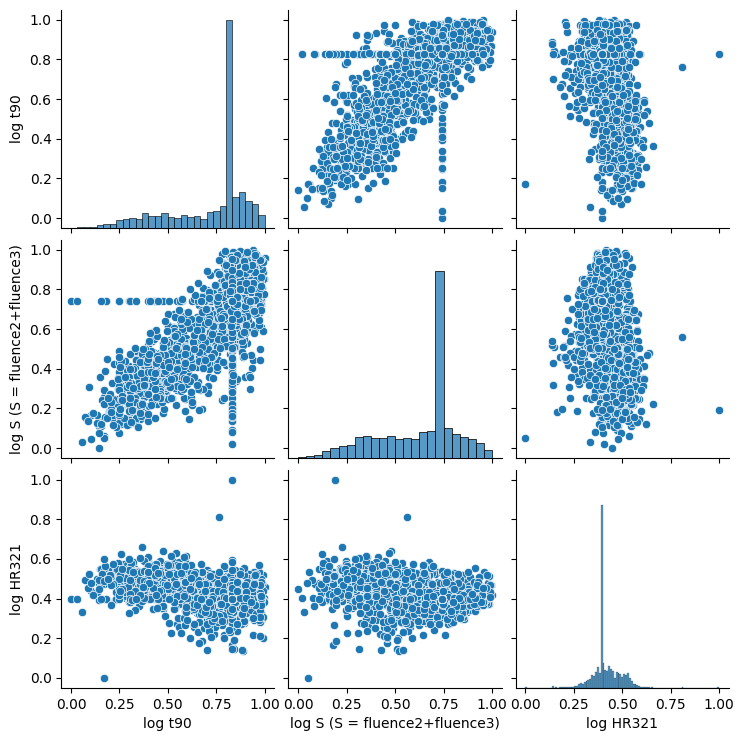

In [33]:
# Pair Plot (Seaborn)
sns.pairplot(df_final_normalized[features])
plt.show()

In [34]:
# MiniSom expects input in numpy array, so we will not convert X to pandas dataframe
X = df_final_normalized.to_numpy()
type(X)
print(X.shape)
print(X)

(1921, 3)
[[0.74056405 0.82980081 0.39747068]
 [0.37862574 0.32341344 0.48530643]
 [0.77576244 0.88717906 0.39150314]
 ...
 [0.22363067 0.36540658 0.65912283]
 [0.74056405 0.82980081 0.39747068]
 [0.65568189 0.77235503 0.37115674]]


In [35]:
df_final_normalized.shape[0]

1921

# Initialising A SOM

A rule of thumb to set the size of the grid for a dimensionality reduction task is that it should contain 5 * sqrt(N) neurons. where N = df_final_normalized.shape[0] = 1921(here) is the number of samples in the dataset to analyze.

E.g. if dataset has 1921 samples, 5 * sqrt(1921) = 219.15 hence a map 15-by-15 should perform well.


In [36]:
som = MiniSom(x=15,y=15,input_len = df_final_normalized.shape[1], sigma = 1.0,learning_rate = 0.5,
            neighborhood_function='gaussian',topology='hexagonal', 
            activation_distance='euclidean', random_seed=45)

# Initialising Random Weights
som.random_weights_init(X)

# Custom training function to display epoch number
def train_som(som, data, num_epochs):
    for epoch in range(num_epochs):
        som.train_random(data, 1,verbose = True)
        print(f'Epoch {epoch + 1}/{num_epochs}')

# Train the SOM
train_som(som, X, 1000)

 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03326176640477417
Epoch 1/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.033350292472393024
Epoch 2/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03340584799895152
Epoch 3/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03333816307171582
Epoch 4/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.033267922275040336
Epoch 5/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.033222106079972405
Epoch 6/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03319728241120485
Epoch 7/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03319120772331812
Epoch 8/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03315496327056159
Epoch 9/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03318186387245361
Epoch 10/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.033184149570414226
Epoch 11/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization er

/opt/conda/lib/python3.10/site-packages/minisom.py:540: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



 quantization error: 0.03346592511827572
Epoch 24/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03352078139384655
Epoch 25/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03357412304715314
Epoch 26/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.033619999161899915
Epoch 27/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03366119403100154
Epoch 28/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03369298748179751
Epoch 29/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03371619539559614
Epoch 30/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.033732762826250075
Epoch 31/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03374280973406979
Epoch 32/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03374584210691518
Epoch 33/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03374867220124551
Epoch 34/1000
 [ 1 / 1 ] 100% - 0:00:00 left 
 quantization error: 0.03375309931832734

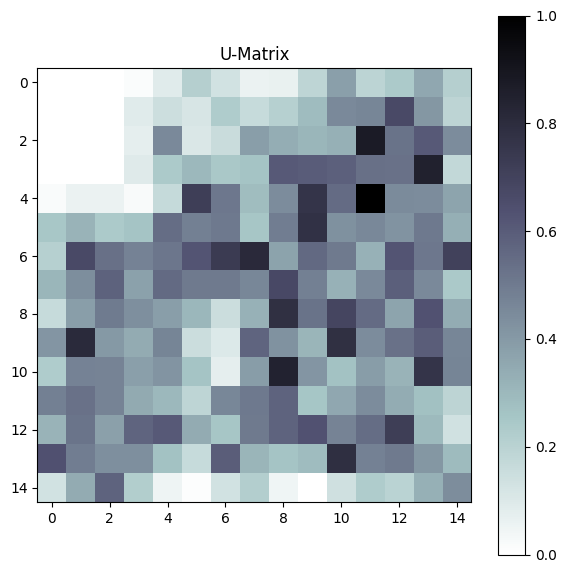

In [37]:
# Visualizing the results
# Compute the U-matrix

u_matrix = som.distance_map().T

# Plot the U-matrix
plt.figure(figsize=(7, 7))
plt.imshow(u_matrix, cmap='bone_r', interpolation='nearest')
plt.colorbar()
plt.title('U-Matrix')
plt.show()